In [61]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl

from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot_2samples

from sklearn.metrics import mean_squared_error




---
# User-defined Functions

In [3]:
def fit_moving_average_trend(series, window=6):
#    return pd.rolling_mean(series, window, center=True)
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index.date, moving_average_trend)
    
def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series, )
    ax.plot(series.index.date, seasons_average_trend, '-')

def plot_trend_data(ax, name, series):
    ax.plot(series.index.date, series)
    ax.set_title("{} Historic LMP".format(name))

---
# Import Data

In [68]:
caiso = pd.read_csv('data/caiso_master.csv')
caiso.drop('Unnamed: 0', axis=1, inplace=True)
caiso['INTERVAL_START_PT'] = pd.to_datetime(caiso['INTERVAL_START_PT']).apply(lambda x: x.replace(tzinfo=None))
caiso['INTERVAL_END_PT'] = pd.to_datetime(caiso['INTERVAL_END_PT']).apply(lambda x: x.replace(tzinfo=None))
caiso['date_hour_start'] = pd.to_datetime(caiso['date_hour_start']).apply(lambda x: x.replace(tzinfo=None))
caiso['OPR_DT_PT'] = pd.to_datetime(caiso['OPR_DT_PT'])#.apply(lambda x: x.replace(tzinfo=None))

caiso.set_index('INTERVAL_START_PT', inplace=True)

caiso.rename({'HH_$_million_BTU_not_seasonal_adj': 'HH_$_mill_BTU', 'total_mw':'total_gen'},axis=1, inplace=True)
caiso['HH_$_mill_BTU'] = pd.to_numeric(caiso['HH_$_mill_BTU'])

In [8]:
caiso.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11519 entries, 2019-02-01 01:00:00 to 2020-05-30 23:00:00
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   INTERVAL_END_PT  11519 non-null  datetime64[ns]
 1   date_hour_start  11518 non-null  datetime64[ns]
 2   OPR_DT_PT        11519 non-null  datetime64[ns]
 3   OPR_HR_PT        11519 non-null  int64         
 4   day_week         11519 non-null  int64         
 5   OPR_INTERVAL     11519 non-null  int64         
 6   $_MWH_np15       11519 non-null  float64       
 7   $_MWH_sp15       11519 non-null  float64       
 8   $_MWH_zp26       11519 non-null  float64       
 9   other            11519 non-null  float64       
 10  solar            11519 non-null  float64       
 11  wind             11519 non-null  float64       
 12  total_mw         11519 non-null  float64       
 13  net_exp_MW       11518 non-null  float64       
 14  loa

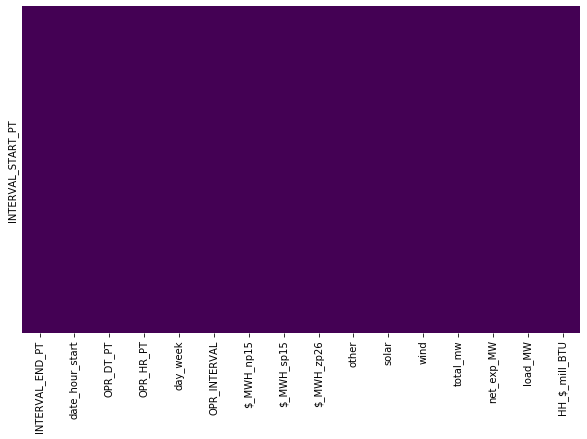

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(caiso.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [10]:
np15_lmp = caiso['$_MWH_np15']
sp15_lmp = caiso['$_MWH_sp15']
zp26_lmp = caiso['$_MWH_zp26']
all_lmp = [np15_lmp, sp15_lmp, zp26_lmp]
hub_names = ['NP15', 'SP15', 'ZP26']
idx_as_str = [str(i) for i in caiso.index]
exog_variables = caiso[['day_week', 'other', 'solar', 'wind', 'load_MW', 'HH_$_mill_BTU']]
num_hubs = range(len(all_lmp))

In [11]:
exog_variables.index[np.isinf(exog_variables).any(1)]

DatetimeIndex([], dtype='datetime64[ns]', name='INTERVAL_START_PT', freq=None)

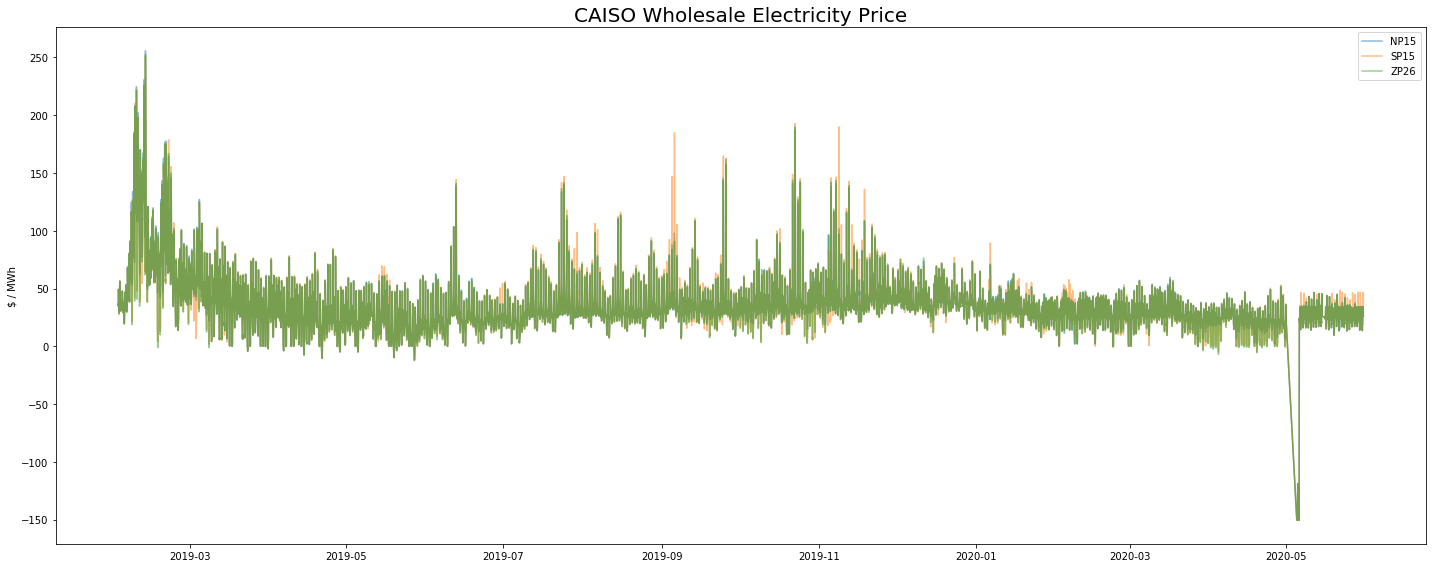

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
for curve, hub in zip(all_lmp, hub_names):
    ax.plot(curve, label=hub, alpha=0.5)
    ax.legend()
ax.set_title('CAISO Wholesale Electricity Price', fontsize=20)
ax.set_ylabel('$ / MWh')
plt.tight_layout();

In [24]:
def calc_stats(curve, name):
    avg = round(curve.mean(), 5)
    med = round(curve.median(), 5)
    std = round(curve.std(), 5)
    print (f"{name} avg. price: {avg}")
    print (f"{name} median price: {med}")
    print(f"{name} std. dev.: {std}")
    print('\n')

In [25]:
for curve, hub in zip(all_lmp, hub_names):
    calc_stats(curve, hub)

NP15 avg. price: 32.8995
NP15 median price: 29.86318
NP15 std. dev.: 21.98975


SP15 avg. price: 32.2308
SP15 median price: 29.36094
SP15 std. dev.: 22.63798


ZP26 avg. price: 31.88004
ZP26 median price: 29.22073
ZP26 std. dev.: 22.14462




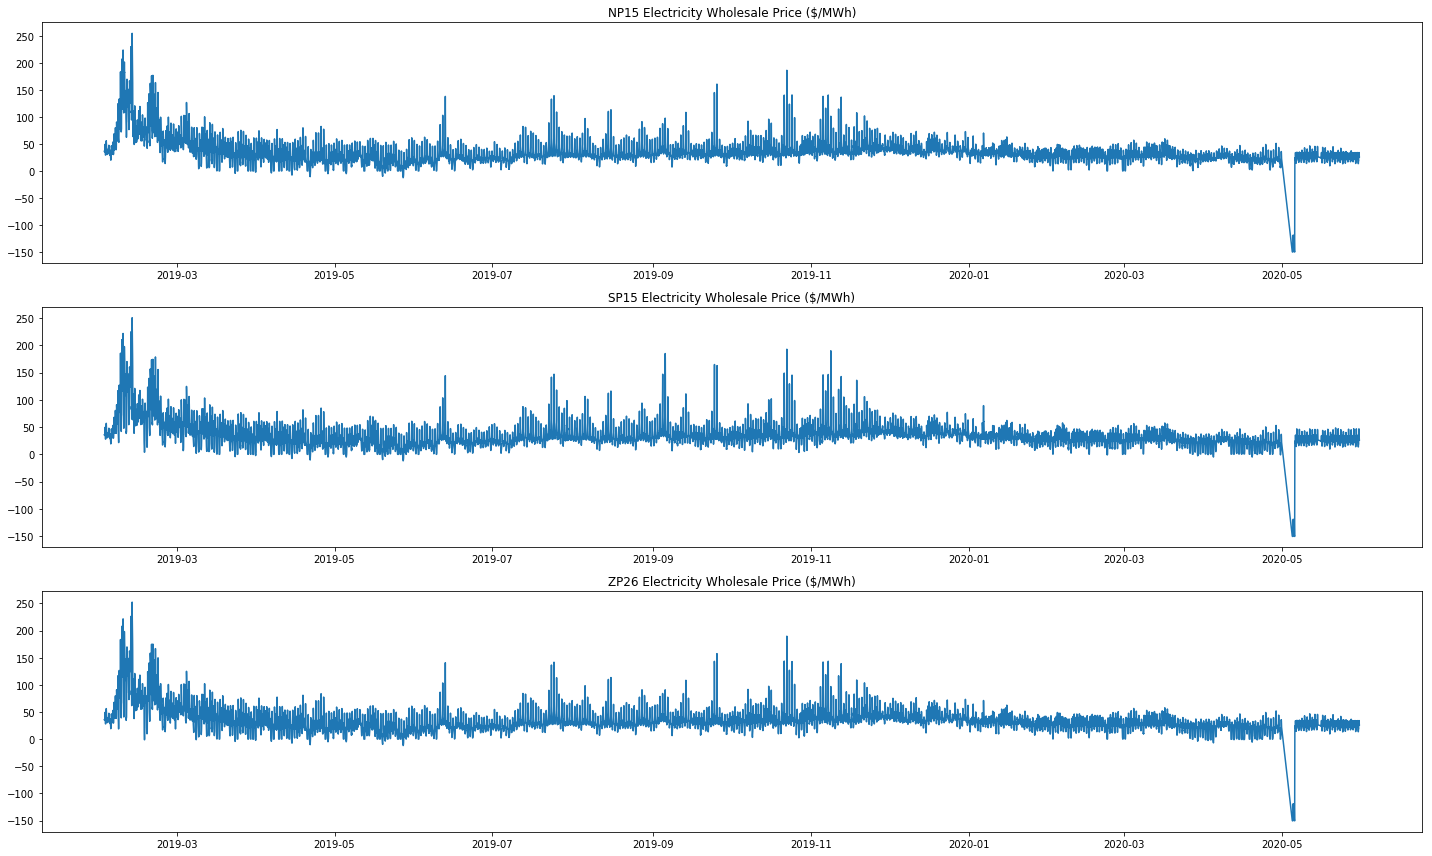

In [245]:
fig, axs = plt.subplots(3, figsize=(20, 12))
hrs_smoothed = 24
for i, name, curve in zip(num_hubs, hub_names, all_lmp):
    axs[i].plot(curve)
    axs[i].set_title(f"{name} Electricity Wholesale Price ($/MWh)")
    plt.tight_layout();

### Moving Average

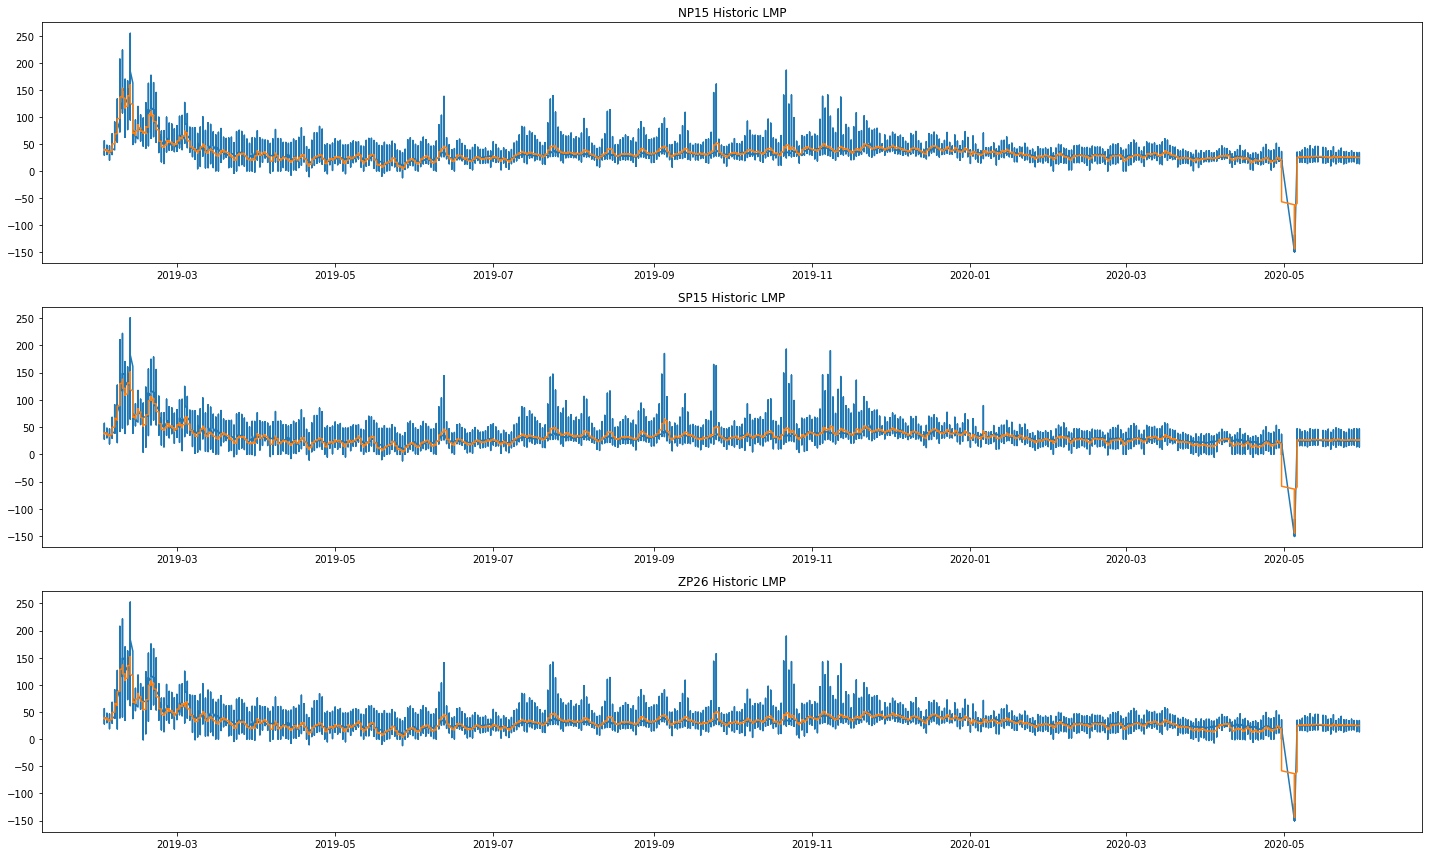

In [60]:
fig, axs = plt.subplots(len(all_lmp), figsize=(20, 12))
hrs_smoothed = 24
for i, name, curve in zip(range(len(all_lmp)), hub_names, all_lmp):
    plot_moving_average_trend(axs[i], name, curve, hrs_smoothed)
plt.tight_layout();

----
# Trend-Seasonal-Residual (TSR) Decomposition

In [35]:
type(np15_lmp.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [66]:
type(np15_lmp.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [84]:

np15_decomp = sm.tsa.seasonal_decompose(np15_lmp, freq=24)
sp15_decomp = sm.tsa.seasonal_decompose(sp15_lmp, freq=30)
zp26_decomp = sm.tsa.seasonal_decompose(caiso['$_MWH_zp26'], freq=30)

In [93]:
def plot_shared_yscales(axs, x, ys, titles, hub_name):
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(f"{title} - {hub_name}")
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))


def plot_seasonal_decomposition(axs, series, sd, hub_name):
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.seasonal, sd.resid],
                        ["Raw Series", "Trend Component $T_t$", "Seasonal Component $S_t$", "Residual Component $R_t$"],
                        hub_name)

### NP15 TSR Decomposition

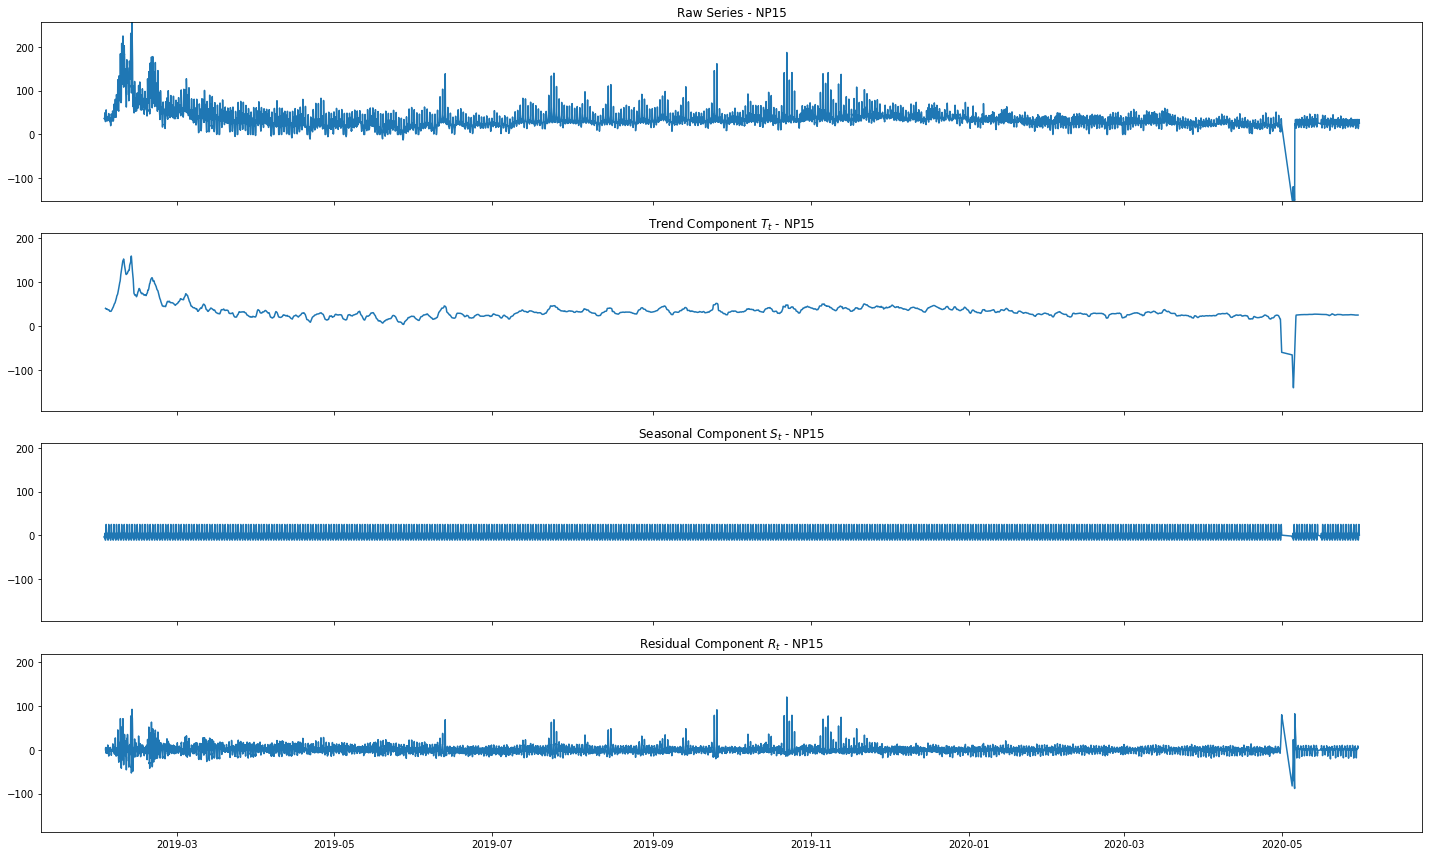

In [94]:
fig, axs = plt.subplots(4, figsize=(20,12), sharex=True)
plot_seasonal_decomposition(axs, np15_lmp, np15_decomp, "NP15")
plt.tight_layout()

### SP15 TSR Decomposition

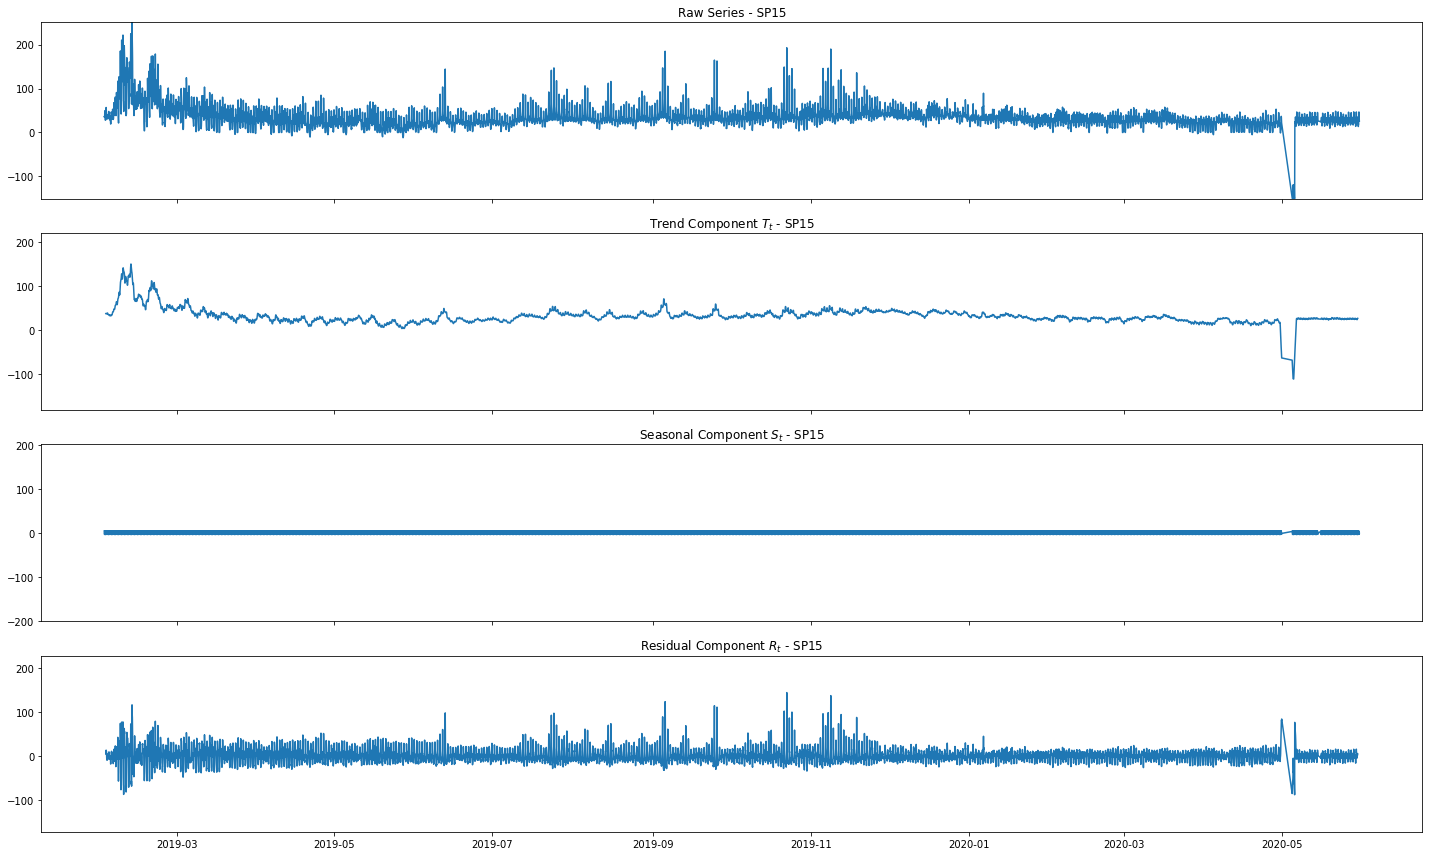

In [96]:
fig, axs = plt.subplots(4, figsize=(20,12), sharex=True)
plot_seasonal_decomposition(axs, sp15_lmp, sp15_decomp, "SP15")
plt.tight_layout()

### ZP26 TSR Decomposition

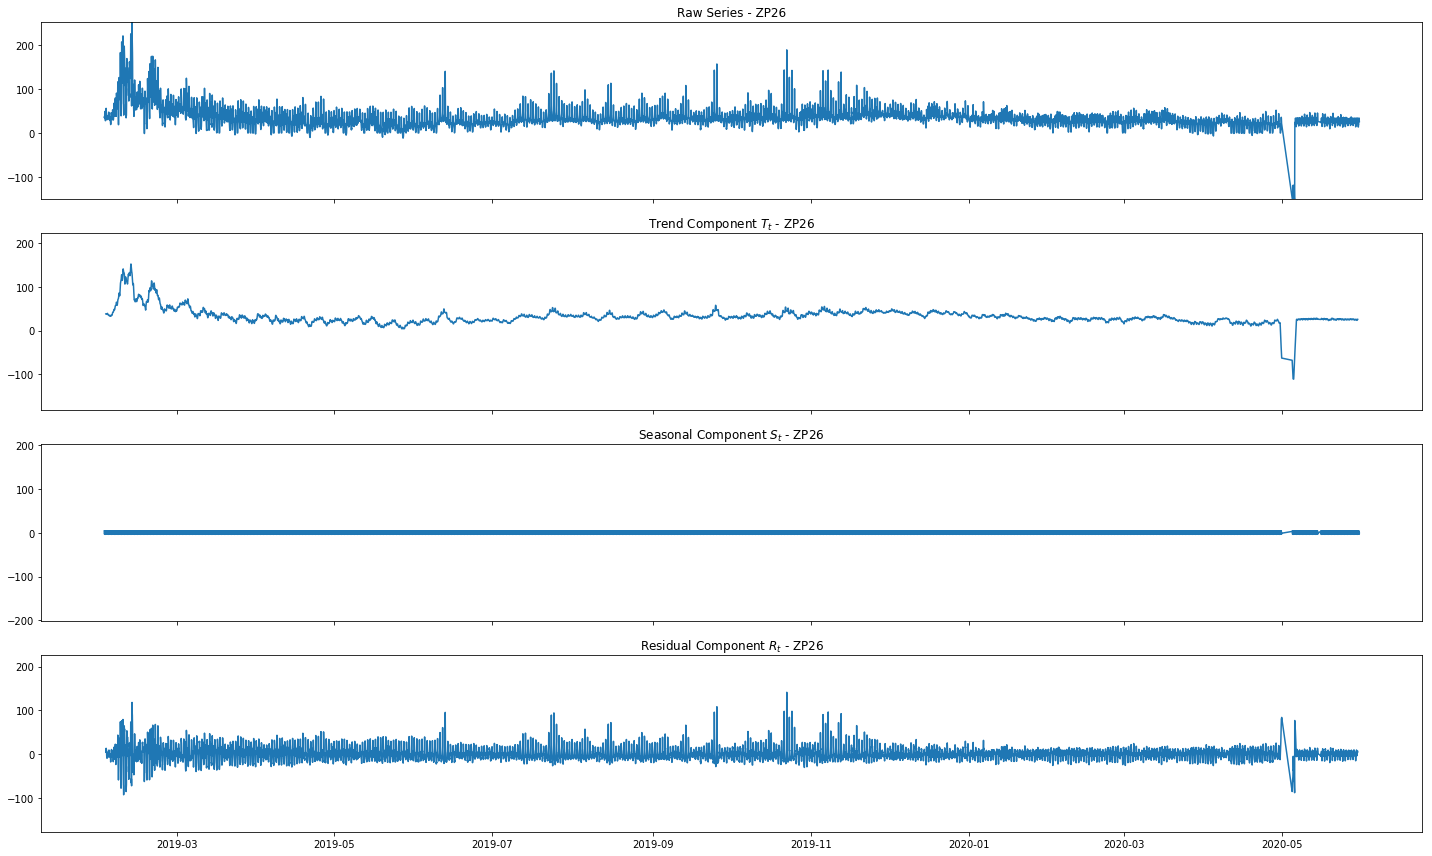

In [97]:
fig, axs = plt.subplots(4, figsize=(20,12), sharex=True)
plot_seasonal_decomposition(axs, zp26_lmp, zp26_decomp, "ZP26")
plt.tight_layout()

---
## Stationary Test

The **Augmented Dickey-Fuller test** is setup as follows:

  - $H_0$: The series is **not-stationary** (specifically, has a *unit root*).
  - $H_{\text{a}}$: The series is stationary.

Each curve's p-value is ~0.0; therefore, I can assume the series is stationary.

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

In [106]:
# 'ct' = constant and trend
for i, curve in enumerate(all_lmp):
    test = sm.tsa.stattools.adfuller(curve, regression='ct')
    print("ADF p-value: {0:.3f}".format(test[1]))

ADF p-value: 0.000
ADF p-value: 0.000
ADF p-value: 0.000


---
# Autocorrelation


Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. Autocorrelation measures the relationship between a variable's current value and its past values

Autocorrelation looks at the direct and indirect effects of the lagged date and intermediate time periods.

In [111]:
def compute_autocorrelation(series, lag=1):
    truncated = series[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return np.corrcoef(series, lagged)[0,1]

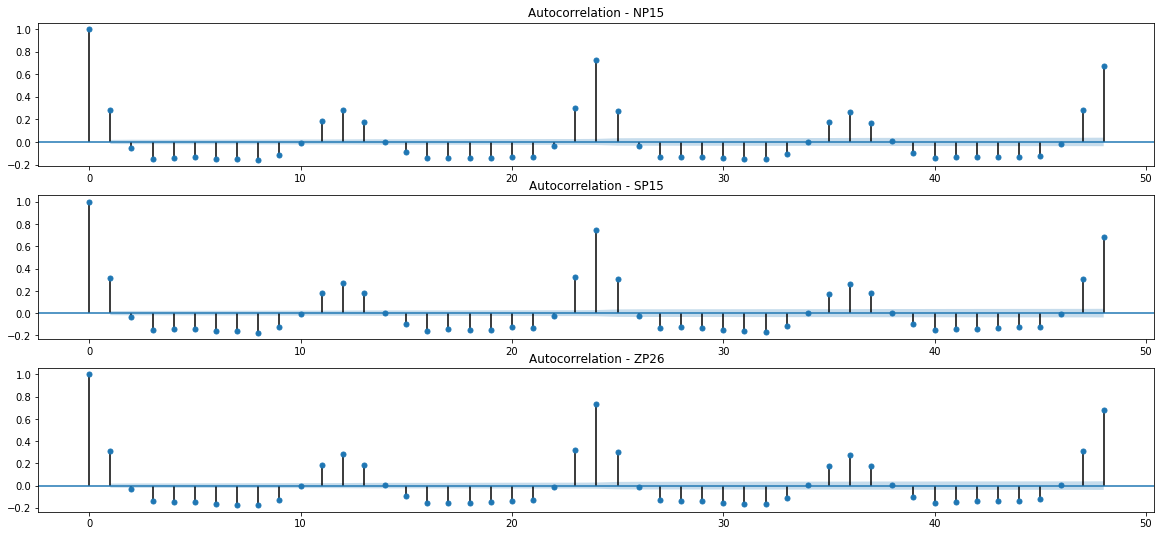

In [133]:
np15_diff = np15_lmp.diff()[1:]
sp15_diff = sp15_lmp.diff()[1:]
zp26_diff = zp26_lmp.diff()[1:]
all_hub_diff = [np15_diff, sp15_diff, zp26_diff]

fig, axs = plt.subplots(3, figsize=(20, 9))

acf_lag = 24 * 2
for i, d, name in zip(lmp_len_rng, all_hub_diff, hub_names):
    _ = sm.graphics.tsa.plot_acf(d, lags=acf_lag, ax=axs[i])
    axs[i].set_title(f"Autocorrelation - {name}")

#### Partial Autocorrelation

In contract to autocorrelation, partial correlation **omits the intermediate time periods** between the lag date/time and present. Partial autocorrelation evaluates if the lagged date/time is a strong predictor of the current price.

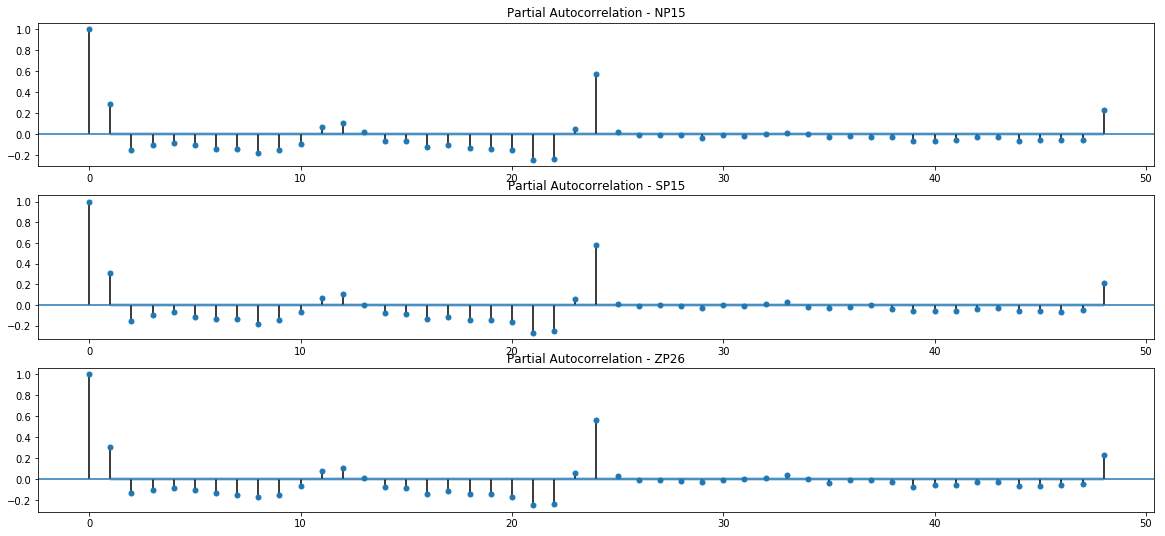

In [132]:
# Does this signify there is no direct interday effect?
# The LMP, more or less, "starts from scratch" each day.
fig, axs = plt.subplots(3, figsize=(20, 9))

pacf_lag = 24*2
for i, d, name in zip(lmp_len_rng, all_hub_diff, hub_names):
    _ = sm.graphics.tsa.plot_pacf(d, lags=pacf_lag, ax=axs[i])
    axs[i].set_title(f"Partial Autocorrelation - {name}")

---
# Data Processing

In [72]:
prcnt_df_for_train = 0.9
prcnt_df_for_val = 0

train_end_mark = int(prcnt_df_for_train * len(caiso))
validation_end_mark = int(prcnt_df_for_val * len(caiso)) + train_end_mark


train_df = caiso.iloc[:train_end_mark, :]
val_df = caiso.iloc[train_end_mark:validation_end_mark, :]
test_df = caiso.iloc[validation_end_mark:, :]

# Train set
np15_lmp_train = train_df['$_MWH_np15'].values
sp15_lmp_train = train_df['$_MWH_sp15']
zp26_lmp_train = train_df['$_MWH_zp26']
exog_train = train_df[['day_week', 'other', 'solar', 'wind', 'total_gen', 'net_exp_MW','load_MW', 'HH_$_mill_BTU']]
train_dates = train_df.index
train_start = train_df

# Validation set
np15_lmp_val = val_df['$_MWH_np15']
sp15_lmp_val = val_df['$_MWH_sp15']
zp26_lmp_val = val_df['$_MWH_zp26']
exog_val = val_df[['day_week', 'other', 'solar', 'wind', 'total_gen', 'net_exp_MW','load_MW', 'HH_$_mill_BTU']]
val_dates = val_df.index

# test set
np15_lmp_test = test_df['$_MWH_np15']
sp15_lmp_test = test_df['$_MWH_sp15']
zp26_lmp_test = test_df['$_MWH_zp26']
exog_test = test_df[['day_week', 'other', 'solar', 'wind','total_gen', 'net_exp_MW','load_MW', 'HH_$_mill_BTU']]
test_dates = test_df.index

# Use lists:
all_train_lmp = [np15_lmp_train, sp15_lmp_train, zp26_lmp_train]
all_val_lmp = [np15_lmp_val, sp15_lmp_val, zp26_lmp_val]
all_lmp = [np15_lmp_test, sp15_lmp_test, zp26_lmp_test]

allocation_check = len(train_df) + len(val_df) + len(test_df) == len(caiso)
print("Dataset allocation check: ", allocation_check)

Dataset allocation check:  True


In [28]:
type(train_df_dates[0])

pandas._libs.tslibs.timestamps.Timestamp

In [233]:
exog_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10367 entries, 2019-02-01 01:00:00 to 2020-04-07 23:00:00
Data columns (total 7 columns):
day_week         10367 non-null int64
other            10367 non-null float64
solar            10367 non-null float64
wind             10367 non-null float64
net_exp_MW       10366 non-null float64
load_MW          10366 non-null float64
HH_$_mill_BTU    10367 non-null float64
dtypes: float64(6), int64(1)
memory usage: 647.9 KB


In [173]:
exog_train.index[np.isinf(exog_train).any(0)]

DatetimeIndex([], dtype='datetime64[ns]', name='INTERVAL_START_PT', freq=None)

---
# Autoregressive Integrated Moving Average (ARIMA) Model

- Autoregression - A model that uses the dependent relationship between an observation and some number of lagged observations.
- Integrated - The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- Moving Average - A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


#### ARIMA Model parameters:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

In [32]:
# ONLY endogenous variables.

p1 = 24
d1 = 1
q1 = 0

np15_arima_endo = ARIMA(endog=np15_lmp_train, dates=train_dates, order=(p1, d1, q1), freq='H').fit()#, exog=exog_train)
sp15_arima_endo = ARIMA(endog=sp15_lmp_train, dates=train_dates, order=(p1, d1, q1), freq='H').fit()#, exog=exog_train)
zp26_arima_endo = ARIMA(endog=zp26_lmp_train, dates=train_dates, order=(p1, d1, q1), freq='H').fit()#, exog=exog_train)


### NP15 ARIMA - Endo Only

In [33]:
print(np15_arima_endo.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                10366
Model:                ARIMA(24, 1, 0)   Log Likelihood              -30245.210
Method:                       css-mle   S.D. of innovations              4.471
Date:                Fri, 05 Jun 2020   AIC                          60542.420
Time:                        16:30:11   BIC                          60730.823
Sample:                    02-01-2019   HQIC                         60606.079
                         - 04-07-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.015     -0.087      0.931      -0.030       0.028
ar.L1.D.y     -0.0533      0.007     -7.170      0.000      -0.068      -0.039
ar.L2.D.y     -0.1501      0.007    -20.165      0.0

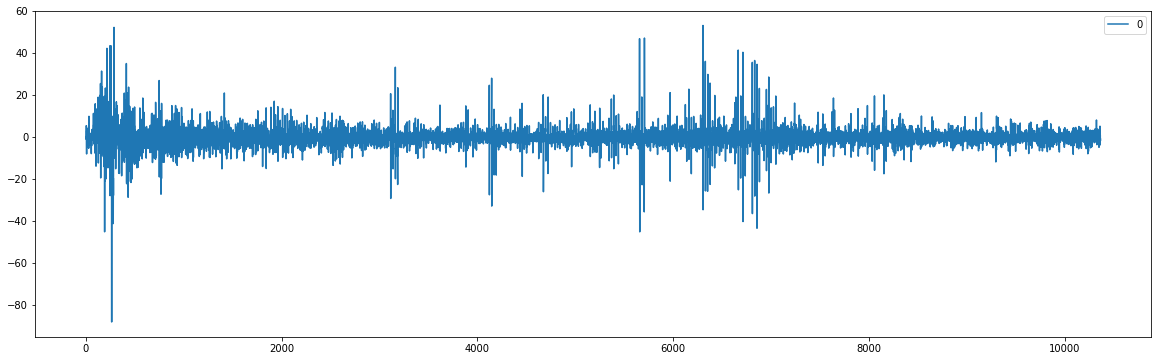

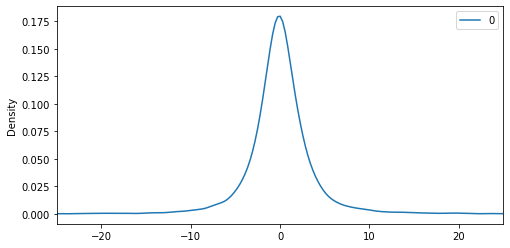

                  0
count  10366.000000
mean       0.000997
std        4.473387
min      -87.902413
25%       -1.524407
50%       -0.047723
75%        1.444720
max       53.194338


In [34]:
np15_arima_endo_resids = pd.DataFrame(np15_arima_endo.resid)
np15_arima_endo_resids.plot(figsize=(20,6))
np15_arima_endo_resids.plot(kind='kde', figsize=(8,4),xlim=(-25,25))
plt.show();
print(np15_arima_endo_resids.describe())

In [37]:
n_steps_endo=24

np_arima_endo_fcst = np15_arima_endo.forecast(steps=n_steps_endo)[0]
mse_np_arima_endo = mean_squared_error(np15_lmp_test[:n_steps_endo], np_arima_endo_fcst)
print('MSE - NP15 Endo Only ARIMA: {}'.format(round(mse_np_arima_endo, 5)))

MSE - NP15 Endo Only ARIMA: 1.92514


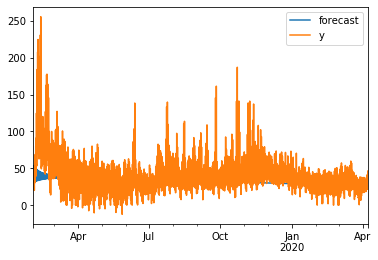

<Figure size 1440x432 with 0 Axes>

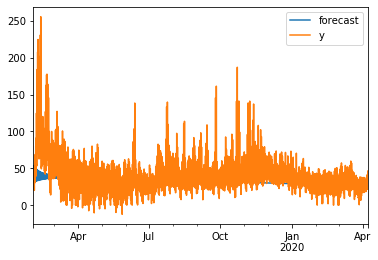

In [60]:
plt.figure(figsize=(20,6))
np15_arima_endo.plot_predict(dynamic=False)

### SP15 ARIMA - Endo Only

In [38]:
print(sp15_arima_endo.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.$_MWH_sp15   No. Observations:                10366
Model:                ARIMA(24, 1, 0)   Log Likelihood              -31022.610
Method:                       css-mle   S.D. of innovations              4.820
Date:                Fri, 05 Jun 2020   AIC                          62097.221
Time:                        16:35:10   BIC                          62285.624
Sample:                    02-01-2019   HQIC                         62160.880
                         - 04-07-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0014      0.015     -0.089      0.929      -0.031       0.029
ar.L1.D.$_MWH_sp15     -0.0423      0.008     -5.628      0.000      -0.057      -0.028
ar.L2.D.$_MWH_sp

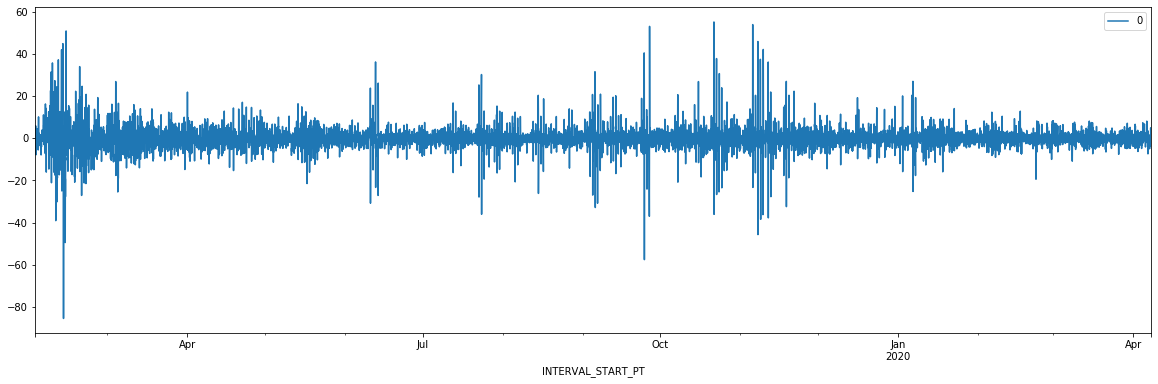

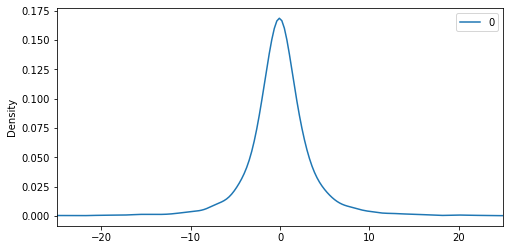

                  0
count  10366.000000
mean       0.000934
std        4.821515
min      -85.381561
25%       -1.611164
50%       -0.034427
75%        1.524483
max       55.125705


In [39]:
sp15_arima_endo_resids = pd.DataFrame(sp15_arima_endo.resid)
sp15_arima_endo_resids.plot(figsize=(20,6))
sp15_arima_endo_resids.plot(kind='kde', figsize=(8,4),xlim=(-25,25))
plt.show();
print(sp15_arima_endo_resids.describe())

In [40]:
sp_arima_endo_fcst = sp15_arima_endo.forecast(steps=n_steps_endo)[0]
mse_sp_arima_endo = mean_squared_error(sp15_lmp_test[:n_steps_endo], sp_arima_endo_fcst)
print('MSE - SP15 ARIMA: {}'.format(round(mse_sp_arima_endo, 5)))

MSE - SP15 ARIMA: 6.34603


### ZP26 ARIMA - Endo Only

In [41]:
print(zp26_arima_endo.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.$_MWH_zp26   No. Observations:                10366
Model:                ARIMA(24, 1, 0)   Log Likelihood              -30618.174
Method:                       css-mle   S.D. of innovations              4.635
Date:                Fri, 05 Jun 2020   AIC                          61288.347
Time:                        16:43:53   BIC                          61476.751
Sample:                    02-01-2019   HQIC                         61352.007
                         - 04-07-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0014      0.014     -0.097      0.923      -0.030       0.027
ar.L1.D.$_MWH_zp26     -0.0529      0.008     -6.974      0.000      -0.068      -0.038
ar.L2.D.$_MWH_zp

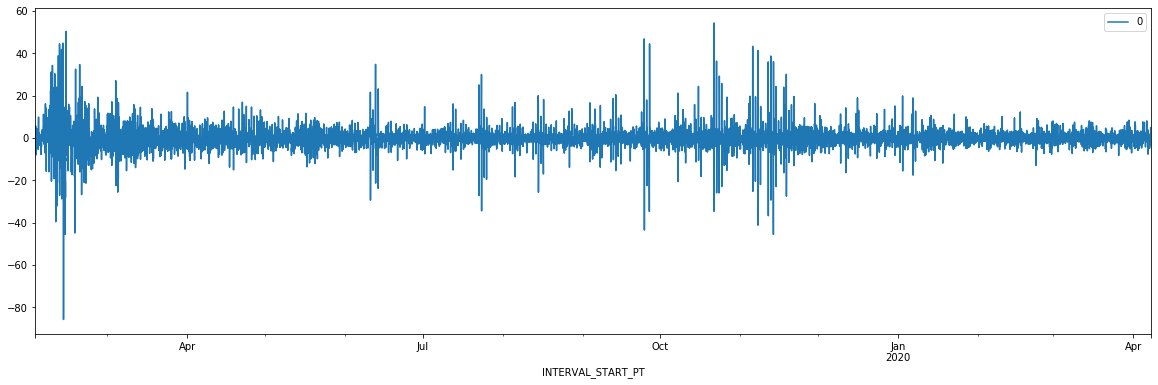

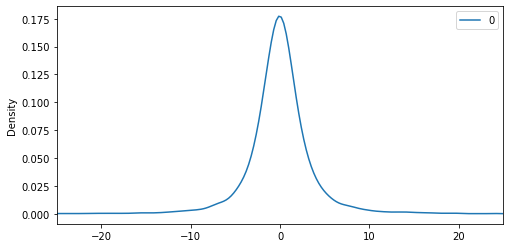

                  0
count  10366.000000
mean       0.000910
std        4.637259
min      -85.734507
25%       -1.536219
50%       -0.047177
75%        1.440190
max       54.320309


In [42]:
zp26_arima_endo_resids = pd.DataFrame(zp26_arima_endo.resid)
zp26_arima_endo_resids.plot(figsize=(20,6))
zp26_arima_endo_resids.plot(kind='kde', figsize=(8,4),xlim=(-25,25))
plt.show();
print(zp26_arima_endo_resids.describe())

In [44]:
zp_arima_endo_fcst = zp26_arima_endo.forecast(steps=n_steps_endo)[0]
mse_zp_arima_endo = mean_squared_error(zp26_lmp_test[:n_steps_endo], zp_arima_endo_fcst)
print('MSE - ZP26 ARIMA: {}'.format(round(mse_zp_arima_endo, 5)))

MSE - ZP26 ARIMA: 8.88611


In [70]:
# afig, axs = plt.subplots(3, figsize=(20, 12))
# baseline_models = [np15_arima_1_fit, sp15_arima_1_fit, zp26_arima_1_fit]
# fcst_start = len(np15_lmp_train)
# fcst_end = fcst_start + 24 * 3

# for i, base, historic, name in zip(num_hubs, baseline_models, all_train_lmp, hub_names):
#     axs[i].plot(train_df_dates, historic)
#     fig = base.plot_predict(fcst_start, fcst_end, dynamic=True, ax=axs[i], plot_insample=False)
#     axs[i].legend.get_texts()[1].set_text('95% Prediction Interval')
#     axs[i].legend(loc='lower left')
#     axs[i].set_title(f'{name} Wholesale Price Forecast ($/MWh)')

----
## Broot force Rolling Moving Average Prediction

In [ ]:
"""

np_historic = [x for x in np15_lmp_train]
pred_np_rolling = list()
for t in range(len(np15_lmp_test)):
    dates_idx = len(np15_lmp_train) + t
    arima_dates = caiso.index[:dates_idx]
    np_roll_model = ARIMA(np_historic, order=(24, 1, 0), dates=arima_dates, freq='H')
    np_roll_fit = np_roll_model.fit(disp=0)
    output = np_roll_fit.forecast()
    yhat_np_roll = output[0]
    pred_np_rolling.append(yhat_np_roll)
    np_obs = np15_lmp_test[t]
    np_historic.append(np_obs)

error_np15_roll = mean_squared_error(np15_lmp_test, pred_np_rolling)
"""

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [ ]:
"""

sp_historic = [x for x in sp15_lmp_train]
pred_sp_rolling = list()
for t in range(len(sp15_lmp_test)):
    dates_idx = len(sp15_lmp_train) + t
    arima_dates = caiso.index[:dates_idx]
    sp_roll_model = ARIMA(sp_historic, order=(24, 1, 0), dates=arima_dates, freq='H')
    sp_roll_fit = sp_roll_model.fit(disp=0)
    output = sp_roll_fit.forecast()
    yhat_sp_roll = output[0]
    pred_sp_rolling.append(yhat_sp_roll)
    sp_obs = sp15_lmp_test[t]
    sp_historic.append(sp_obs)

error_sp_roll = mean_squared_error(sp15_lmp_test, pred_sp_rolling)
"""

In [ ]:
"""
zp_historic = [x for x in zp26_lmp_train]
pred_zp_rolling = list()
for t in range(len(zp26_lmp_test)):
    dates_idx = len(zp26_lmp_train) + t
    arima_dates = caiso.index[:dates_idx]
    zp_roll_model = ARIMA(zp_historic, order=(24, 1, 0), dates=arima_dates, freq='H')
    zp_roll_fit = zp_roll_model.fit(disp=0)
    output = zp_roll_fit.forecast()
    yhat_zp_roll = output[0]
    pred_zp_rolling.append(yhat_zp_roll)
    zp_obs = zp26_lmp_test[t]
    zp_historic.append(zp_obs)

error_zp_roll = mean_squared_error(zp26_lmp_test, pred_zp_rolling)
"""

---
# ARIMA w/ Exogenous Variables

Text(0.5, 1, 'Check for Null Values in Exogenous Train Set')

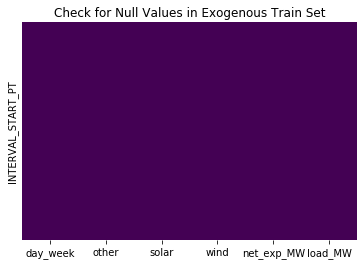

In [48]:
sns.heatmap(exog_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Check for Null Values in Exogenous Train Set')

(10367, 6)

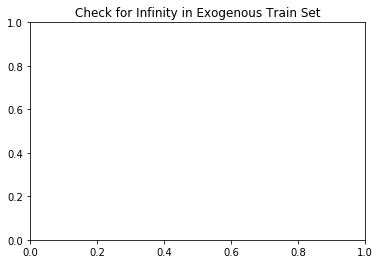

In [55]:

# sns.heatmap(exog_train.isinf(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Check for Infinity in Exogenous Train Set')
exog_train.values.shape
#for x in exog_train.values:
    #print(np.all(np.isinf(x)))

In [74]:
p2 = 24
d2 = 1
q2 = 0

np_arima_exo = ARIMA(endog=np15_lmp_train, dates=train_dates, order=(p2, d2, q2), freq='H', exog=exog_train['total_gen']).fit()
sp_arima_exo = ARIMA(endog=sp15_lmp_train, dates=train_dates, order=(p2, d2, q2), freq='H', exog=exog_train['total_gen']).fit()
zp_arima_exo = ARIMA(endog=zp26_lmp_train, dates=train_dates, order=(p2, d2, q2), freq='H', exog=exog_train['total_gen']).fit()


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [66]:
type(exog_train.iloc[:,0])

pandas.core.series.Series

In [ ]:
data1 = [x + random() for x in range(1, 100)]
data2 = [x + random() for x in range(101, 200)]
# fit model
model = SARIMAX(data1, exog=data2, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
exog2 = [200 + random()]
yhat = model_fit.predict(len(data1), len(data1), exog=[exog2])